# Transform spike rates to behaviour using conv and RNN

## Setup

### Environment Setup

Configure the local or Google Colab environments.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os
import sys
try:
    # Only on works on Google Colab
    from google.colab import files
    %tensorflow_version 2.x
    os.chdir('..')
    
    # Configure kaggle if necessary
    if not (Path.home() / '.kaggle').is_dir():
        uploaded = files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        if 'kaggle.json' in uploaded.keys():
            !mkdir -p ~/.kaggle
            !mv kaggle.json ~/.kaggle/
            !chmod 600 ~/.kaggle/kaggle.json
    
    !pip install git+https://github.com/SachsLab/indl.git
    
    if Path.cwd().stem == 'MonkeyPFCSaccadeStudies':
        os.chdir(Path.cwd().parent)
    
    if not (Path.cwd() / 'MonkeyPFCSaccadeStudies').is_dir():
        !git clone --single-branch --recursive https://github.com/SachsLab/MonkeyPFCSaccadeStudies.git
        sys.path.append(str(Path.cwd() / 'MonkeyPFCSaccadeStudies'))
    
    os.chdir('MonkeyPFCSaccadeStudies')
        
    !pip install -q kaggle
    
    # Latest version of SKLearn
    !pip install -U scikit-learn
    
    IN_COLAB = True
    
except ModuleNotFoundError:    
    # chdir to MonkeyPFCSaccadeStudies
    if Path.cwd().stem == 'Analysis':
        os.chdir(Path.cwd().parent.parent)
        
    # Add indl repository to path.
    # Eventually this should already be pip installed, but it's still under heavy development so this is easier for now.
    check_dir = Path.cwd()
    while not (check_dir / 'Tools').is_dir():
        check_dir = check_dir / '..'
    indl_path = check_dir / 'Tools' / 'Neurophys' / 'indl'
    sys.path.append(str(indl_path))
    
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')
    
    IN_COLAB = False

# Try to clear any logs from previous runs
if (Path.cwd() / 'logs').is_dir():
    import shutil
    try:
        shutil.rmtree(str(Path.cwd() / 'logs'))
    except PermissionError:
        print("Unable to remove logs directory.")

In [3]:
# Additional imports
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
from indl.display import turbo_cmap

In [4]:
plt.rcParams.update({
    'axes.titlesize': 24,
    'axes.labelsize': 20,
    'lines.linewidth': 2,
    'lines.markersize': 5,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 18,
    'figure.figsize': (6.4, 6.4)
})

### Download Data (if necessary)

In [5]:
if IN_COLAB:
    data_path = Path.cwd() / 'data' / 'monkey_pfc' / 'converted'
else:
    data_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed'

if not (data_path).is_dir():
    !kaggle datasets download --unzip --path {str(data_path)} cboulay/macaque-8a-spikes-rates-and-saccades
    print("Finished downloading and extracting data.")
else:
    print("Data directory found. Skipping download.")

Data directory found. Skipping download.


### (Prepare to) Load Data

We will use a custom function `load_macaque_pfc` to load the data into memory.

There are 4 different strings to be passed to the import `x_chunk` argument:
* 'analogsignals' - if present. Returns 1 kHz LFPs
* 'gaze'          - Returns 2-channel gaze data.
* 'spikerates'    - Returns smoothed spikerates
* 'spiketrains'

The `y_type` argument can be
* 'pair and choice' - returns Y as np.array of (target_pair, choice_within_pair)
* 'encoded input' - returns Y as np.array of shape (n_samples, 10) (explained below)
* 'replace with column name' - returns Y as a vector of per-trial values. e.g., 'sacClass'

The actual data we load depends on the particular analysis below.

In [6]:
from misc.misc import sess_infos, load_macaque_pfc, dec_from_enc

load_kwargs = {
    'valid_outcomes': (0,),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, 1.45),
    'verbose': True,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}

## Decoding trial class (0:7) from spike rates

### Load Data

Load the per-trial spikerates and saccadeClass (0:7)

In [7]:
test_sess_ix = 1
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
print(f"\nImporting session {sess_id}")
X_rates, Y_class, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs)
Y_class = tf.keras.utils.to_categorical(Y_class, num_classes=8)


Importing session sra3_1_j_050_00+
Found 285 trials, 171 timestamps(-0.25 to 1.45 at 100.0 Hz), 32 channels
Returning Y as sacClass with shape (285, 1).
Axis info has: dict_keys(['instance_data', 'instance_times', 'fs', 'timestamps', 'channel_names', 'channel_locs'])


### Create Model

Our model objective is to transform timeseries segments into probabilities of each class.

Let's start with a function to make the model:

In [23]:
from indl.model import parts
from indl.model.helper import check_inputs
from indl.regularizers import KernelLengthRegularizer
from tensorflow.keras import layers

@check_inputs
def make_model(
    _input,
    F1=8, kernLength=25, F1_kern_reg=None,
    D=2, D_pooling=4,
    n_rnn=32,
    dropoutRate=0.25,
    activation='relu',
    l1_reg=0.000, l2_reg=0.000,
    norm_rate=0.25,
    latent_dim=16,
    return_model=True
):
    _y = _input
    
    input_shape = _input.shape.as_list()
    
    # Usually the filter dimension does not exist so let's add that.
    if len(input_shape) < 4:
        input_shape = input_shape + [1]
    
    # The Conv layers are insensitive to the number of samples in the time dimension.
    # To make it possible for this trained model to be applied to segments of different
    # durations, we need to explicitly state that we don't care about the number of samples.
    # input_shape[2] = -1  # Comment out during debug
    _y = layers.Reshape(input_shape[1:])(_input)  # Note that Reshape ignores the batch dimension.

    # Temporal filter-alike
    _y = parts.EEGNetEncPartA(_y,
                              F1=F1, F1_kernLength=kernLength,
                              F1_kern_reg=F1_kern_reg,
                              l1_reg=l1_reg, l2_reg=l2_reg,
                              return_model=False)

    # Spatial-filter-alike.
    _y = parts.EEGNetEncPartB(_y,
                              D=D,
                              D_pooling=D_pooling,
                              dropoutRate=dropoutRate,
                              activation=activation,
                              l1_reg=l1_reg, l2_reg=l2_reg,
                              return_model=False)
    
    # Drop len=1 channel dimension
    # Restore time-dimension that was stripped out by EEGNetEnc
    _y = layers.Reshape((_input.shape.as_list()[2] // D_pooling, F1 * D))(_y)
    
    _y = tf.keras.layers.GRU(n_rnn,
                              dropout=dropoutRate,
                              kernel_regularizer=tf.keras.regularizers.l2(2*l2_reg),
                              recurrent_regularizer=tf.keras.regularizers.l2(2*l2_reg),
                              return_sequences=False,
                              stateful=False,
                              name='lstm')(_y)
    
    # Dense
    _y = parts.Bottleneck(_y, latent_dim=latent_dim, activation=activation)
    
    # Classify
    _y = parts.Classify(_y, n_classes=8, norm_rate=norm_rate)
    

    if return_model is False:
        return _y
    else:
        return tf.keras.models.Model(inputs=_input, outputs=_y)

In [24]:
LABEL_SMOOTHING = 0.2
model_kwargs = dict(
    F1=8, kernLength=25, F1_kern_reg=None,
    D=2, D_pooling=4,
    n_rnn=10,
    dropoutRate=0.40,
    activation='relu',
    l1_reg=0.0001, l2_reg=0.003,
    norm_rate=0.35,
    latent_dim=10
)

tf.keras.backend.clear_session()

randseed = 12345
random.seed(randseed)
np.random.seed(randseed)
tf.random.set_seed(randseed)

input_spec = tf.data.Dataset.from_tensor_slices(X_rates).batch(16, drop_remainder=True).element_spec
model = make_model(
    input_spec,
    **model_kwargs
)
optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])
model.summary()
if False:
    tf.keras.utils.plot_model(
        model,
        to_file='model.png',
        show_shapes=True,
        show_layer_names=True,
        rankdir='TB',
        expand_nested=False,
        dpi=96
    )

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 171)]         0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 171, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 171, 8)        208       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 171, 8)        32        
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 1, 171, 16)        528       
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 171, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 1, 171, 16)        0     

### Training Loop

In [25]:
from sklearn.model_selection import StratifiedKFold

N_SPLITS = 10
BATCH_SIZE = 64
EPOCHS = 220


def get_hists_acc(sess_id, verbose=1):
    print(f"Processing session {sess_id}...")
    X_rates, Y_class, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs)
    
    splitter = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=0)
    split_ix = 0
    histories = []
    per_fold_eval = []
    per_fold_true = []

    for trn, vld in splitter.split(X_rates, Y_class):
        print(f"\tSplit {split_ix + 1} of {N_SPLITS}")
        _y = tf.keras.utils.to_categorical(Y_class, num_classes=8)
        
        ds_train = tf.data.Dataset.from_tensor_slices((X_rates[trn], _y[trn]))
        ds_valid = tf.data.Dataset.from_tensor_slices((X_rates[vld], _y[vld]))

        # cast data types to GPU-friendly types.
        ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
        ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

        # TODO: augmentations (random slicing?)

        ds_train = ds_train.shuffle(len(trn) + 1)
        ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
        ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

        tf.keras.backend.clear_session()
        
        randseed = 12345
        random.seed(randseed)
        np.random.seed(randseed)
        tf.random.set_seed(randseed)
        
        model = make_model(
            ds_train.element_spec[0],
            **model_kwargs
        )
        optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
        loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
        model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])
        
        best_model_path = f'r2c_lstm_{sess_id}_split{split_ix}.h5'
        callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                filepath=best_model_path,
                # Path where to save the model
                # The two parameters below mean that we will overwrite
                # the current checkpoint if and only if
                # the `val_loss` score has improved.
                save_best_only=True,
                monitor='val_accuracy',
                verbose=verbose)
        ]

        hist = model.fit(x=ds_train, epochs=EPOCHS,
                         verbose=verbose,
                         validation_data=ds_valid,
                         callbacks=callbacks)
        # tf.keras.models.save_model(model, 'model.h5')
        histories.append(hist.history)
        
        model = tf.keras.models.load_model(best_model_path)
        per_fold_eval.append(model(X_rates[vld]).numpy())
        per_fold_true.append(Y_class[vld])
        
        split_ix += 1
        
    # Combine histories into one dictionary.
    history = {}
    for h in histories:
        for k,v in h.items():
            if k not in history:
                history[k] = v
            else:
                history[k].append(np.nan)
                history[k].extend(v)
                
    pred_y = np.concatenate([np.argmax(_, axis=1) for _ in per_fold_eval])
    true_y = np.concatenate(per_fold_true).flatten()
    accuracy = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"Session {sess_id} overall accuracy: {accuracy}%")
    
    return history, accuracy
        

Processing session sra3_2_j_037_00+03...
Found 160 trials, 171 timestamps(-0.25 to 1.45 at 100.0 Hz), 32 channels
Returning Y as sacClass with shape (160, 1).
Axis info has: dict_keys(['instance_data', 'instance_times', 'fs', 'timestamps', 'channel_names', 'channel_locs'])
	Split 1 of 10
Epoch 1/220

Epoch 00001: val_accuracy improved from -inf to 0.29412, saving model to r2c_lstm_sra3_2_j_037_00+03_split0.h5
2/2 - 3s - loss: 2.2501 - accuracy: 0.2109 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/220

Epoch 00002: val_accuracy improved from 0.29412 to 0.47059, saving model to r2c_lstm_sra3_2_j_037_00+03_split0.h5
2/2 - 0s - loss: 2.2390 - accuracy: 0.3906 - val_loss: 2.2659 - val_accuracy: 0.4706
Epoch 3/220

Epoch 00003: val_accuracy did not improve from 0.47059
2/2 - 0s - loss: 2.2438 - accuracy: 0.3203 - val_loss: 2.2605 - val_accuracy: 0.4706
Epoch 4/220

Epoch 00004: val_accuracy did not improve from 0.47059
2/2 - 0s - loss: 2.2304 - accuracy: 0.3359 - val_loss: 2.2545

Epoch 105/220

Epoch 00105: val_accuracy did not improve from 0.58824
2/2 - 0s - loss: 1.3818 - accuracy: 0.4688 - val_loss: 1.3700 - val_accuracy: 0.5294
Epoch 106/220

Epoch 00106: val_accuracy did not improve from 0.58824
2/2 - 0s - loss: 1.3760 - accuracy: 0.5156 - val_loss: 1.3688 - val_accuracy: 0.5294
Epoch 107/220

Epoch 00107: val_accuracy did not improve from 0.58824
2/2 - 0s - loss: 1.3753 - accuracy: 0.4766 - val_loss: 1.3680 - val_accuracy: 0.5294
Epoch 108/220

Epoch 00108: val_accuracy did not improve from 0.58824
2/2 - 0s - loss: 1.3668 - accuracy: 0.5859 - val_loss: 1.3665 - val_accuracy: 0.5294
Epoch 109/220

Epoch 00109: val_accuracy did not improve from 0.58824
2/2 - 0s - loss: 1.3722 - accuracy: 0.5547 - val_loss: 1.3654 - val_accuracy: 0.5294
Epoch 110/220

Epoch 00110: val_accuracy did not improve from 0.58824
2/2 - 0s - loss: 1.3792 - accuracy: 0.5312 - val_loss: 1.3644 - val_accuracy: 0.5294
Epoch 111/220

Epoch 00111: val_accuracy did not improve from 0.58824


Epoch 158/220

Epoch 00158: val_accuracy did not improve from 0.58824
2/2 - 0s - loss: 1.3349 - accuracy: 0.5469 - val_loss: 1.3338 - val_accuracy: 0.5882
Epoch 159/220

Epoch 00159: val_accuracy did not improve from 0.58824
2/2 - 0s - loss: 1.3447 - accuracy: 0.5859 - val_loss: 1.3315 - val_accuracy: 0.5882
Epoch 160/220

Epoch 00160: val_accuracy did not improve from 0.58824
2/2 - 0s - loss: 1.3271 - accuracy: 0.6641 - val_loss: 1.3321 - val_accuracy: 0.5882
Epoch 161/220

Epoch 00161: val_accuracy did not improve from 0.58824
2/2 - 0s - loss: 1.3281 - accuracy: 0.6250 - val_loss: 1.3327 - val_accuracy: 0.5882
Epoch 162/220

Epoch 00162: val_accuracy did not improve from 0.58824
2/2 - 0s - loss: 1.3182 - accuracy: 0.6562 - val_loss: 1.3331 - val_accuracy: 0.5882
Epoch 163/220

Epoch 00163: val_accuracy improved from 0.58824 to 0.64706, saving model to r2c_lstm_sra3_2_j_037_00+03_split0.h5
2/2 - 0s - loss: 1.3122 - accuracy: 0.6641 - val_loss: 1.3331 - val_accuracy: 0.6471
Epoch 164/2

Epoch 211/220

Epoch 00211: val_accuracy did not improve from 0.64706
2/2 - 0s - loss: 1.1798 - accuracy: 0.7891 - val_loss: 1.5489 - val_accuracy: 0.3529
Epoch 212/220

Epoch 00212: val_accuracy did not improve from 0.64706
2/2 - 0s - loss: 1.1558 - accuracy: 0.8516 - val_loss: 1.5592 - val_accuracy: 0.3529
Epoch 213/220

Epoch 00213: val_accuracy did not improve from 0.64706
2/2 - 0s - loss: 1.1609 - accuracy: 0.8203 - val_loss: 1.5755 - val_accuracy: 0.3529
Epoch 214/220

Epoch 00214: val_accuracy did not improve from 0.64706
2/2 - 0s - loss: 1.1191 - accuracy: 0.8984 - val_loss: 1.5918 - val_accuracy: 0.3529
Epoch 215/220

Epoch 00215: val_accuracy did not improve from 0.64706
2/2 - 0s - loss: 1.1560 - accuracy: 0.8281 - val_loss: 1.6104 - val_accuracy: 0.2941
Epoch 216/220

Epoch 00216: val_accuracy did not improve from 0.64706
2/2 - 0s - loss: 1.1238 - accuracy: 0.8359 - val_loss: 1.6273 - val_accuracy: 0.2941
Epoch 217/220

Epoch 00217: val_accuracy did not improve from 0.64706


Epoch 43/220

Epoch 00043: val_accuracy did not improve from 0.58824
2/2 - 0s - loss: 1.4866 - accuracy: 0.5312 - val_loss: 1.5152 - val_accuracy: 0.5294
Epoch 44/220

Epoch 00044: val_accuracy did not improve from 0.58824
2/2 - 0s - loss: 1.4982 - accuracy: 0.3984 - val_loss: 1.5055 - val_accuracy: 0.5294
Epoch 45/220

Epoch 00045: val_accuracy did not improve from 0.58824
2/2 - 0s - loss: 1.4702 - accuracy: 0.5078 - val_loss: 1.4956 - val_accuracy: 0.5294
Epoch 46/220

Epoch 00046: val_accuracy did not improve from 0.58824
2/2 - 0s - loss: 1.4728 - accuracy: 0.4453 - val_loss: 1.4883 - val_accuracy: 0.5294
Epoch 47/220

Epoch 00047: val_accuracy did not improve from 0.58824
2/2 - 0s - loss: 1.4688 - accuracy: 0.4844 - val_loss: 1.4812 - val_accuracy: 0.5294
Epoch 48/220

Epoch 00048: val_accuracy did not improve from 0.58824
2/2 - 0s - loss: 1.4716 - accuracy: 0.5078 - val_loss: 1.4748 - val_accuracy: 0.5294
Epoch 49/220

Epoch 00049: val_accuracy did not improve from 0.58824
2/2 - 0

Epoch 97/220

Epoch 00097: val_accuracy did not improve from 0.58824
2/2 - 0s - loss: 1.3770 - accuracy: 0.5156 - val_loss: 1.3739 - val_accuracy: 0.5294
Epoch 98/220

Epoch 00098: val_accuracy did not improve from 0.58824
2/2 - 0s - loss: 1.3872 - accuracy: 0.4922 - val_loss: 1.3731 - val_accuracy: 0.5294
Epoch 99/220

Epoch 00099: val_accuracy did not improve from 0.58824
2/2 - 0s - loss: 1.3799 - accuracy: 0.5625 - val_loss: 1.3716 - val_accuracy: 0.5294
Epoch 100/220

Epoch 00100: val_accuracy did not improve from 0.58824
2/2 - 0s - loss: 1.3843 - accuracy: 0.4844 - val_loss: 1.3702 - val_accuracy: 0.5294
Epoch 101/220

Epoch 00101: val_accuracy did not improve from 0.58824
2/2 - 0s - loss: 1.3731 - accuracy: 0.5703 - val_loss: 1.3700 - val_accuracy: 0.5294
Epoch 102/220

Epoch 00102: val_accuracy did not improve from 0.58824
2/2 - 0s - loss: 1.3629 - accuracy: 0.5703 - val_loss: 1.3688 - val_accuracy: 0.5294
Epoch 103/220

Epoch 00103: val_accuracy did not improve from 0.58824
2/2

Epoch 150/220

Epoch 00150: val_accuracy did not improve from 0.58824
2/2 - 0s - loss: 1.3201 - accuracy: 0.6484 - val_loss: 1.3426 - val_accuracy: 0.5882
Epoch 151/220

Epoch 00151: val_accuracy did not improve from 0.58824
2/2 - 0s - loss: 1.3228 - accuracy: 0.6562 - val_loss: 1.3427 - val_accuracy: 0.5882
Epoch 152/220

Epoch 00152: val_accuracy did not improve from 0.58824
2/2 - 0s - loss: 1.3332 - accuracy: 0.5781 - val_loss: 1.3438 - val_accuracy: 0.5882
Epoch 153/220

Epoch 00153: val_accuracy did not improve from 0.58824
2/2 - 0s - loss: 1.3034 - accuracy: 0.6875 - val_loss: 1.3446 - val_accuracy: 0.5882
Epoch 154/220

Epoch 00154: val_accuracy did not improve from 0.58824
2/2 - 0s - loss: 1.3121 - accuracy: 0.6172 - val_loss: 1.3459 - val_accuracy: 0.5882
Epoch 155/220

Epoch 00155: val_accuracy did not improve from 0.58824
2/2 - 0s - loss: 1.3001 - accuracy: 0.6641 - val_loss: 1.3483 - val_accuracy: 0.5882
Epoch 156/220

Epoch 00156: val_accuracy did not improve from 0.58824


Epoch 203/220

Epoch 00203: val_accuracy did not improve from 0.64706
2/2 - 0s - loss: 1.1981 - accuracy: 0.8125 - val_loss: 1.4134 - val_accuracy: 0.5294
Epoch 204/220

Epoch 00204: val_accuracy did not improve from 0.64706
2/2 - 0s - loss: 1.1917 - accuracy: 0.7891 - val_loss: 1.4310 - val_accuracy: 0.5294
Epoch 205/220

Epoch 00205: val_accuracy did not improve from 0.64706
2/2 - 0s - loss: 1.1572 - accuracy: 0.8359 - val_loss: 1.4359 - val_accuracy: 0.5294
Epoch 206/220

Epoch 00206: val_accuracy did not improve from 0.64706
2/2 - 0s - loss: 1.1529 - accuracy: 0.8359 - val_loss: 1.4401 - val_accuracy: 0.5294
Epoch 207/220

Epoch 00207: val_accuracy did not improve from 0.64706
2/2 - 0s - loss: 1.1569 - accuracy: 0.8438 - val_loss: 1.4361 - val_accuracy: 0.5294
Epoch 208/220

Epoch 00208: val_accuracy did not improve from 0.64706
2/2 - 0s - loss: 1.1722 - accuracy: 0.7656 - val_loss: 1.4426 - val_accuracy: 0.5294
Epoch 209/220

Epoch 00209: val_accuracy did not improve from 0.64706


Epoch 36/220

Epoch 00036: val_accuracy did not improve from 0.64706
2/2 - 0s - loss: 1.5503 - accuracy: 0.4062 - val_loss: 1.6204 - val_accuracy: 0.5294
Epoch 37/220

Epoch 00037: val_accuracy did not improve from 0.64706
2/2 - 0s - loss: 1.5438 - accuracy: 0.4688 - val_loss: 1.6011 - val_accuracy: 0.5294
Epoch 38/220

Epoch 00038: val_accuracy did not improve from 0.64706
2/2 - 0s - loss: 1.5499 - accuracy: 0.5469 - val_loss: 1.5819 - val_accuracy: 0.5294
Epoch 39/220

Epoch 00039: val_accuracy did not improve from 0.64706
2/2 - 0s - loss: 1.4996 - accuracy: 0.4922 - val_loss: 1.5659 - val_accuracy: 0.5294
Epoch 40/220

Epoch 00040: val_accuracy did not improve from 0.64706
2/2 - 0s - loss: 1.4955 - accuracy: 0.5391 - val_loss: 1.5504 - val_accuracy: 0.5294
Epoch 41/220

Epoch 00041: val_accuracy did not improve from 0.64706
2/2 - 0s - loss: 1.4940 - accuracy: 0.4375 - val_loss: 1.5380 - val_accuracy: 0.5294
Epoch 42/220

Epoch 00042: val_accuracy did not improve from 0.64706
2/2 - 0

Epoch 90/220

Epoch 00090: val_accuracy did not improve from 0.64706
2/2 - 0s - loss: 1.3915 - accuracy: 0.5547 - val_loss: 1.3811 - val_accuracy: 0.5294
Epoch 91/220

Epoch 00091: val_accuracy did not improve from 0.64706
2/2 - 0s - loss: 1.3918 - accuracy: 0.5234 - val_loss: 1.3801 - val_accuracy: 0.5294
Epoch 92/220

Epoch 00092: val_accuracy did not improve from 0.64706
2/2 - 0s - loss: 1.3825 - accuracy: 0.5781 - val_loss: 1.3796 - val_accuracy: 0.5294
Epoch 93/220

Epoch 00093: val_accuracy did not improve from 0.64706
2/2 - 0s - loss: 1.3895 - accuracy: 0.5703 - val_loss: 1.3782 - val_accuracy: 0.5294
Epoch 94/220

Epoch 00094: val_accuracy did not improve from 0.64706
2/2 - 0s - loss: 1.3799 - accuracy: 0.5781 - val_loss: 1.3773 - val_accuracy: 0.5294
Epoch 95/220

Epoch 00095: val_accuracy did not improve from 0.64706
2/2 - 0s - loss: 1.3828 - accuracy: 0.5078 - val_loss: 1.3763 - val_accuracy: 0.5294
Epoch 96/220

Epoch 00096: val_accuracy did not improve from 0.64706
2/2 - 0

Epoch 143/220

Epoch 00143: val_accuracy did not improve from 0.64706
2/2 - 0s - loss: 1.3310 - accuracy: 0.6719 - val_loss: 1.3494 - val_accuracy: 0.5294
Epoch 144/220

Epoch 00144: val_accuracy did not improve from 0.64706
2/2 - 0s - loss: 1.3251 - accuracy: 0.6406 - val_loss: 1.3499 - val_accuracy: 0.5294
Epoch 145/220

Epoch 00145: val_accuracy did not improve from 0.64706
2/2 - 0s - loss: 1.3208 - accuracy: 0.6250 - val_loss: 1.3515 - val_accuracy: 0.5294
Epoch 146/220

Epoch 00146: val_accuracy did not improve from 0.64706
2/2 - 0s - loss: 1.3243 - accuracy: 0.6094 - val_loss: 1.3546 - val_accuracy: 0.5294
Epoch 147/220

Epoch 00147: val_accuracy did not improve from 0.64706
2/2 - 0s - loss: 1.3204 - accuracy: 0.6797 - val_loss: 1.3548 - val_accuracy: 0.5294
Epoch 148/220

Epoch 00148: val_accuracy did not improve from 0.64706
2/2 - 0s - loss: 1.3336 - accuracy: 0.6562 - val_loss: 1.3571 - val_accuracy: 0.5294
Epoch 149/220

Epoch 00149: val_accuracy did not improve from 0.64706


Epoch 196/220

Epoch 00196: val_accuracy did not improve from 0.64706
2/2 - 0s - loss: 1.1876 - accuracy: 0.8203 - val_loss: 1.5051 - val_accuracy: 0.2941
Epoch 197/220

Epoch 00197: val_accuracy did not improve from 0.64706
2/2 - 0s - loss: 1.1569 - accuracy: 0.8359 - val_loss: 1.5075 - val_accuracy: 0.2941
Epoch 198/220

Epoch 00198: val_accuracy did not improve from 0.64706
2/2 - 0s - loss: 1.1635 - accuracy: 0.7969 - val_loss: 1.5191 - val_accuracy: 0.1765
Epoch 199/220

Epoch 00199: val_accuracy did not improve from 0.64706
2/2 - 0s - loss: 1.1745 - accuracy: 0.7734 - val_loss: 1.5307 - val_accuracy: 0.1765
Epoch 200/220

Epoch 00200: val_accuracy did not improve from 0.64706
2/2 - 0s - loss: 1.1577 - accuracy: 0.7812 - val_loss: 1.5316 - val_accuracy: 0.1765
Epoch 201/220

Epoch 00201: val_accuracy did not improve from 0.64706
2/2 - 0s - loss: 1.1868 - accuracy: 0.8047 - val_loss: 1.5286 - val_accuracy: 0.1765
Epoch 202/220

Epoch 00202: val_accuracy did not improve from 0.64706


Epoch 28/220

Epoch 00028: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.7280 - accuracy: 0.4766 - val_loss: 1.8497 - val_accuracy: 0.5000
Epoch 29/220

Epoch 00029: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.6901 - accuracy: 0.5391 - val_loss: 1.8199 - val_accuracy: 0.5000
Epoch 30/220

Epoch 00030: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.6771 - accuracy: 0.5234 - val_loss: 1.7909 - val_accuracy: 0.5000
Epoch 31/220

Epoch 00031: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.6292 - accuracy: 0.5391 - val_loss: 1.7624 - val_accuracy: 0.5000
Epoch 32/220

Epoch 00032: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.5969 - accuracy: 0.5312 - val_loss: 1.7351 - val_accuracy: 0.5000
Epoch 33/220

Epoch 00033: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.5935 - accuracy: 0.4844 - val_loss: 1.7089 - val_accuracy: 0.5000
Epoch 34/220

Epoch 00034: val_accuracy did not improve from 0.50000
2/2 - 0


Epoch 00134: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.3478 - accuracy: 0.5078 - val_loss: 1.3454 - val_accuracy: 0.5000
Epoch 135/220

Epoch 00135: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.3591 - accuracy: 0.5000 - val_loss: 1.3449 - val_accuracy: 0.5000
Epoch 136/220

Epoch 00136: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.3406 - accuracy: 0.6094 - val_loss: 1.3443 - val_accuracy: 0.5000
Epoch 137/220

Epoch 00137: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.3502 - accuracy: 0.5391 - val_loss: 1.3435 - val_accuracy: 0.5000
Epoch 138/220

Epoch 00138: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.3378 - accuracy: 0.5859 - val_loss: 1.3432 - val_accuracy: 0.5000
Epoch 139/220

Epoch 00139: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.3557 - accuracy: 0.5234 - val_loss: 1.3418 - val_accuracy: 0.5000
Epoch 140/220

Epoch 00140: val_accuracy did not improve from 0.50000
2/2 - 0s - los

Epoch 187/220

Epoch 00187: val_accuracy did not improve from 0.56250
2/2 - 0s - loss: 1.2306 - accuracy: 0.7188 - val_loss: 1.3961 - val_accuracy: 0.3750
Epoch 188/220

Epoch 00188: val_accuracy did not improve from 0.56250
2/2 - 0s - loss: 1.2403 - accuracy: 0.8047 - val_loss: 1.4005 - val_accuracy: 0.3125
Epoch 189/220

Epoch 00189: val_accuracy did not improve from 0.56250
2/2 - 0s - loss: 1.2017 - accuracy: 0.8203 - val_loss: 1.4051 - val_accuracy: 0.3125
Epoch 190/220

Epoch 00190: val_accuracy did not improve from 0.56250
2/2 - 0s - loss: 1.2455 - accuracy: 0.7578 - val_loss: 1.4039 - val_accuracy: 0.3750
Epoch 191/220

Epoch 00191: val_accuracy did not improve from 0.56250
2/2 - 0s - loss: 1.2049 - accuracy: 0.7578 - val_loss: 1.4078 - val_accuracy: 0.3750
Epoch 192/220

Epoch 00192: val_accuracy did not improve from 0.56250
2/2 - 0s - loss: 1.2126 - accuracy: 0.7891 - val_loss: 1.4008 - val_accuracy: 0.3125
Epoch 193/220

Epoch 00193: val_accuracy did not improve from 0.56250


Epoch 72/220

Epoch 00072: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.4138 - accuracy: 0.5391 - val_loss: 1.4061 - val_accuracy: 0.5000
Epoch 73/220

Epoch 00073: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.4090 - accuracy: 0.5703 - val_loss: 1.4042 - val_accuracy: 0.5000
Epoch 74/220

Epoch 00074: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.4134 - accuracy: 0.5469 - val_loss: 1.4028 - val_accuracy: 0.5000
Epoch 75/220

Epoch 00075: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.4182 - accuracy: 0.5000 - val_loss: 1.4005 - val_accuracy: 0.5000
Epoch 76/220

Epoch 00076: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.3973 - accuracy: 0.5938 - val_loss: 1.3991 - val_accuracy: 0.5000
Epoch 77/220

Epoch 00077: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.3993 - accuracy: 0.6016 - val_loss: 1.3977 - val_accuracy: 0.5000
Epoch 78/220

Epoch 00078: val_accuracy did not improve from 0.50000
2/2 - 0


Epoch 00125: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.3659 - accuracy: 0.4922 - val_loss: 1.3482 - val_accuracy: 0.5000
Epoch 126/220

Epoch 00126: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.3532 - accuracy: 0.5781 - val_loss: 1.3474 - val_accuracy: 0.5000
Epoch 127/220

Epoch 00127: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.3524 - accuracy: 0.6094 - val_loss: 1.3467 - val_accuracy: 0.5000
Epoch 128/220

Epoch 00128: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.3503 - accuracy: 0.5547 - val_loss: 1.3463 - val_accuracy: 0.5000
Epoch 129/220

Epoch 00129: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.3561 - accuracy: 0.5703 - val_loss: 1.3456 - val_accuracy: 0.5000
Epoch 130/220

Epoch 00130: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.3474 - accuracy: 0.6094 - val_loss: 1.3445 - val_accuracy: 0.5000
Epoch 131/220

Epoch 00131: val_accuracy did not improve from 0.50000
2/2 - 0s - los

Epoch 178/220

Epoch 00178: val_accuracy did not improve from 0.56250
2/2 - 0s - loss: 1.2541 - accuracy: 0.7344 - val_loss: 1.3593 - val_accuracy: 0.5000
Epoch 179/220

Epoch 00179: val_accuracy improved from 0.56250 to 0.62500, saving model to r2c_lstm_sra3_2_j_037_00+03_split4.h5
2/2 - 0s - loss: 1.2536 - accuracy: 0.7891 - val_loss: 1.3605 - val_accuracy: 0.6250
Epoch 180/220

Epoch 00180: val_accuracy did not improve from 0.62500
2/2 - 0s - loss: 1.2618 - accuracy: 0.7969 - val_loss: 1.3600 - val_accuracy: 0.6250
Epoch 181/220

Epoch 00181: val_accuracy did not improve from 0.62500
2/2 - 0s - loss: 1.2384 - accuracy: 0.7734 - val_loss: 1.3645 - val_accuracy: 0.5625
Epoch 182/220

Epoch 00182: val_accuracy did not improve from 0.62500
2/2 - 0s - loss: 1.2532 - accuracy: 0.7734 - val_loss: 1.3661 - val_accuracy: 0.5000
Epoch 183/220

Epoch 00183: val_accuracy did not improve from 0.62500
2/2 - 0s - loss: 1.2492 - accuracy: 0.7500 - val_loss: 1.3634 - val_accuracy: 0.5625
Epoch 184/2


Epoch 00010: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 2.1656 - accuracy: 0.4766 - val_loss: 2.2143 - val_accuracy: 0.5000
Epoch 11/220

Epoch 00011: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 2.1471 - accuracy: 0.5000 - val_loss: 2.2040 - val_accuracy: 0.5000
Epoch 12/220

Epoch 00012: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 2.1330 - accuracy: 0.4688 - val_loss: 2.1931 - val_accuracy: 0.4375
Epoch 13/220

Epoch 00013: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 2.1255 - accuracy: 0.5000 - val_loss: 2.1811 - val_accuracy: 0.4375
Epoch 14/220

Epoch 00014: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 2.1026 - accuracy: 0.5469 - val_loss: 2.1682 - val_accuracy: 0.4375
Epoch 15/220

Epoch 00015: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 2.0919 - accuracy: 0.5469 - val_loss: 2.1542 - val_accuracy: 0.4375
Epoch 16/220

Epoch 00016: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 2.0

Epoch 64/220

Epoch 00064: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.4457 - accuracy: 0.4609 - val_loss: 1.4307 - val_accuracy: 0.5000
Epoch 65/220

Epoch 00065: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.4136 - accuracy: 0.5859 - val_loss: 1.4290 - val_accuracy: 0.5000
Epoch 66/220

Epoch 00066: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.4339 - accuracy: 0.5078 - val_loss: 1.4269 - val_accuracy: 0.5000
Epoch 67/220

Epoch 00067: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.4274 - accuracy: 0.5391 - val_loss: 1.4250 - val_accuracy: 0.5000
Epoch 68/220

Epoch 00068: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.4204 - accuracy: 0.5547 - val_loss: 1.4229 - val_accuracy: 0.5000
Epoch 69/220

Epoch 00069: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.4228 - accuracy: 0.5000 - val_loss: 1.4218 - val_accuracy: 0.5000
Epoch 70/220

Epoch 00070: val_accuracy did not improve from 0.50000
2/2 - 0


Epoch 00117: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.3727 - accuracy: 0.5078 - val_loss: 1.3584 - val_accuracy: 0.5000
Epoch 118/220

Epoch 00118: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.3711 - accuracy: 0.5078 - val_loss: 1.3574 - val_accuracy: 0.5000
Epoch 119/220

Epoch 00119: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.3539 - accuracy: 0.5781 - val_loss: 1.3567 - val_accuracy: 0.5000
Epoch 120/220

Epoch 00120: val_accuracy improved from 0.50000 to 0.56250, saving model to r2c_lstm_sra3_2_j_037_00+03_split5.h5
2/2 - 0s - loss: 1.3631 - accuracy: 0.5391 - val_loss: 1.3558 - val_accuracy: 0.5625
Epoch 121/220

Epoch 00121: val_accuracy did not improve from 0.56250
2/2 - 0s - loss: 1.3682 - accuracy: 0.5547 - val_loss: 1.3550 - val_accuracy: 0.5000
Epoch 122/220

Epoch 00122: val_accuracy did not improve from 0.56250
2/2 - 0s - loss: 1.3570 - accuracy: 0.5625 - val_loss: 1.3539 - val_accuracy: 0.5625
Epoch 123/220

Epoch 0012

Epoch 170/220

Epoch 00170: val_accuracy did not improve from 0.62500
2/2 - 0s - loss: 1.2601 - accuracy: 0.7656 - val_loss: 1.4063 - val_accuracy: 0.3750
Epoch 171/220

Epoch 00171: val_accuracy did not improve from 0.62500
2/2 - 0s - loss: 1.2593 - accuracy: 0.7031 - val_loss: 1.4117 - val_accuracy: 0.3125
Epoch 172/220

Epoch 00172: val_accuracy did not improve from 0.62500
2/2 - 0s - loss: 1.2459 - accuracy: 0.7500 - val_loss: 1.4144 - val_accuracy: 0.3125
Epoch 173/220

Epoch 00173: val_accuracy did not improve from 0.62500
2/2 - 0s - loss: 1.2793 - accuracy: 0.6797 - val_loss: 1.4143 - val_accuracy: 0.3125
Epoch 174/220

Epoch 00174: val_accuracy did not improve from 0.62500
2/2 - 0s - loss: 1.2428 - accuracy: 0.7969 - val_loss: 1.4142 - val_accuracy: 0.3125
Epoch 175/220

Epoch 00175: val_accuracy did not improve from 0.62500
2/2 - 0s - loss: 1.2561 - accuracy: 0.6875 - val_loss: 1.4185 - val_accuracy: 0.3750
Epoch 176/220

Epoch 00176: val_accuracy did not improve from 0.62500


Epoch 3/220

Epoch 00003: val_accuracy did not improve from 0.43750
2/2 - 0s - loss: 2.2393 - accuracy: 0.3203 - val_loss: 2.2660 - val_accuracy: 0.4375
Epoch 4/220

Epoch 00004: val_accuracy did not improve from 0.43750
2/2 - 0s - loss: 2.2327 - accuracy: 0.3672 - val_loss: 2.2601 - val_accuracy: 0.4375
Epoch 5/220

Epoch 00005: val_accuracy did not improve from 0.43750
2/2 - 0s - loss: 2.2316 - accuracy: 0.3672 - val_loss: 2.2536 - val_accuracy: 0.4375
Epoch 6/220

Epoch 00006: val_accuracy did not improve from 0.43750
2/2 - 0s - loss: 2.2105 - accuracy: 0.4688 - val_loss: 2.2466 - val_accuracy: 0.4375
Epoch 7/220

Epoch 00007: val_accuracy did not improve from 0.43750
2/2 - 0s - loss: 2.2028 - accuracy: 0.4141 - val_loss: 2.2388 - val_accuracy: 0.4375
Epoch 8/220

Epoch 00008: val_accuracy did not improve from 0.43750
2/2 - 0s - loss: 2.1965 - accuracy: 0.5000 - val_loss: 2.2309 - val_accuracy: 0.4375
Epoch 9/220

Epoch 00009: val_accuracy did not improve from 0.43750
2/2 - 0s - los

Epoch 56/220

Epoch 00056: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.4360 - accuracy: 0.5625 - val_loss: 1.4442 - val_accuracy: 0.5000
Epoch 57/220

Epoch 00057: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.4283 - accuracy: 0.4922 - val_loss: 1.4416 - val_accuracy: 0.5000
Epoch 58/220

Epoch 00058: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.4305 - accuracy: 0.5391 - val_loss: 1.4393 - val_accuracy: 0.5000
Epoch 59/220

Epoch 00059: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.4360 - accuracy: 0.5234 - val_loss: 1.4363 - val_accuracy: 0.5000
Epoch 60/220

Epoch 00060: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.4395 - accuracy: 0.5156 - val_loss: 1.4340 - val_accuracy: 0.5000
Epoch 61/220

Epoch 00061: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.4318 - accuracy: 0.5781 - val_loss: 1.4311 - val_accuracy: 0.5000
Epoch 62/220

Epoch 00062: val_accuracy did not improve from 0.50000
2/2 - 0

Epoch 162/220

Epoch 00162: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.3145 - accuracy: 0.6484 - val_loss: 1.4001 - val_accuracy: 0.4375
Epoch 163/220

Epoch 00163: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.2723 - accuracy: 0.7500 - val_loss: 1.4040 - val_accuracy: 0.4375
Epoch 164/220

Epoch 00164: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.2667 - accuracy: 0.6953 - val_loss: 1.4102 - val_accuracy: 0.3750
Epoch 165/220

Epoch 00165: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.3094 - accuracy: 0.6328 - val_loss: 1.4175 - val_accuracy: 0.3750
Epoch 166/220

Epoch 00166: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.2656 - accuracy: 0.7188 - val_loss: 1.4237 - val_accuracy: 0.3750
Epoch 167/220

Epoch 00167: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.2432 - accuracy: 0.7812 - val_loss: 1.4325 - val_accuracy: 0.3750
Epoch 168/220

Epoch 00168: val_accuracy did not improve from 0.50000


Epoch 215/220

Epoch 00215: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.0986 - accuracy: 0.9219 - val_loss: 1.8050 - val_accuracy: 0.3125
Epoch 216/220

Epoch 00216: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.0734 - accuracy: 0.8984 - val_loss: 1.8249 - val_accuracy: 0.3125
Epoch 217/220

Epoch 00217: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.1019 - accuracy: 0.8906 - val_loss: 1.8346 - val_accuracy: 0.3125
Epoch 218/220

Epoch 00218: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.1104 - accuracy: 0.8906 - val_loss: 1.8450 - val_accuracy: 0.3125
Epoch 219/220

Epoch 00219: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.0741 - accuracy: 0.9297 - val_loss: 1.8424 - val_accuracy: 0.3125
Epoch 220/220

Epoch 00220: val_accuracy did not improve from 0.50000
2/2 - 0s - loss: 1.1221 - accuracy: 0.8359 - val_loss: 1.8487 - val_accuracy: 0.3750
	Split 8 of 10
Epoch 1/220

Epoch 00001: val_accuracy improved from -i

Epoch 00100: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.3904 - accuracy: 0.4766 - val_loss: 1.3757 - val_accuracy: 0.5333
Epoch 101/220

Epoch 00101: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.3763 - accuracy: 0.5234 - val_loss: 1.3750 - val_accuracy: 0.5333
Epoch 102/220

Epoch 00102: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.3736 - accuracy: 0.5391 - val_loss: 1.3738 - val_accuracy: 0.5333
Epoch 103/220

Epoch 00103: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.3740 - accuracy: 0.5312 - val_loss: 1.3719 - val_accuracy: 0.5333
Epoch 104/220

Epoch 00104: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.3808 - accuracy: 0.4844 - val_loss: 1.3710 - val_accuracy: 0.5333
Epoch 105/220

Epoch 00105: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.3719 - accuracy: 0.5391 - val_loss: 1.3708 - val_accuracy: 0.5333
Epoch 106/220

Epoch 00106: val_accuracy did not improve from 0.53333
2/2 - 0s - loss

Epoch 153/220

Epoch 00153: val_accuracy did not improve from 0.60000
2/2 - 0s - loss: 1.3098 - accuracy: 0.6172 - val_loss: 1.3363 - val_accuracy: 0.5333
Epoch 154/220

Epoch 00154: val_accuracy did not improve from 0.60000
2/2 - 0s - loss: 1.3226 - accuracy: 0.6016 - val_loss: 1.3365 - val_accuracy: 0.6000
Epoch 155/220

Epoch 00155: val_accuracy did not improve from 0.60000
2/2 - 0s - loss: 1.3226 - accuracy: 0.6250 - val_loss: 1.3355 - val_accuracy: 0.6000
Epoch 156/220

Epoch 00156: val_accuracy did not improve from 0.60000
2/2 - 0s - loss: 1.3079 - accuracy: 0.6172 - val_loss: 1.3374 - val_accuracy: 0.6000
Epoch 157/220

Epoch 00157: val_accuracy did not improve from 0.60000
2/2 - 0s - loss: 1.3095 - accuracy: 0.6641 - val_loss: 1.3380 - val_accuracy: 0.6000
Epoch 158/220

Epoch 00158: val_accuracy improved from 0.60000 to 0.66667, saving model to r2c_lstm_sra3_2_j_037_00+03_split7.h5
2/2 - 0s - loss: 1.2968 - accuracy: 0.6328 - val_loss: 1.3387 - val_accuracy: 0.6667
Epoch 159/2

Epoch 206/220

Epoch 00206: val_accuracy did not improve from 0.66667
2/2 - 0s - loss: 1.1466 - accuracy: 0.8750 - val_loss: 1.5329 - val_accuracy: 0.3333
Epoch 207/220

Epoch 00207: val_accuracy did not improve from 0.66667
2/2 - 0s - loss: 1.1634 - accuracy: 0.8125 - val_loss: 1.5324 - val_accuracy: 0.3333
Epoch 208/220

Epoch 00208: val_accuracy did not improve from 0.66667
2/2 - 0s - loss: 1.1718 - accuracy: 0.8047 - val_loss: 1.5316 - val_accuracy: 0.3333
Epoch 209/220

Epoch 00209: val_accuracy did not improve from 0.66667
2/2 - 0s - loss: 1.1716 - accuracy: 0.8125 - val_loss: 1.5382 - val_accuracy: 0.3333
Epoch 210/220

Epoch 00210: val_accuracy did not improve from 0.66667
2/2 - 0s - loss: 1.1838 - accuracy: 0.8281 - val_loss: 1.5451 - val_accuracy: 0.3333
Epoch 211/220

Epoch 00211: val_accuracy did not improve from 0.66667
2/2 - 0s - loss: 1.1679 - accuracy: 0.8047 - val_loss: 1.5245 - val_accuracy: 0.3333
Epoch 212/220

Epoch 00212: val_accuracy did not improve from 0.66667


Epoch 39/220

Epoch 00039: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.5090 - accuracy: 0.4531 - val_loss: 1.5769 - val_accuracy: 0.5333
Epoch 40/220

Epoch 00040: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.5080 - accuracy: 0.4609 - val_loss: 1.5608 - val_accuracy: 0.5333
Epoch 41/220

Epoch 00041: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.4871 - accuracy: 0.5000 - val_loss: 1.5480 - val_accuracy: 0.5333
Epoch 42/220

Epoch 00042: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.4741 - accuracy: 0.5625 - val_loss: 1.5349 - val_accuracy: 0.5333
Epoch 43/220

Epoch 00043: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.4826 - accuracy: 0.5078 - val_loss: 1.5231 - val_accuracy: 0.5333
Epoch 44/220

Epoch 00044: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.4929 - accuracy: 0.5391 - val_loss: 1.5129 - val_accuracy: 0.5333
Epoch 45/220

Epoch 00045: val_accuracy did not improve from 0.53333
2/2 - 0

Epoch 93/220

Epoch 00093: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.4041 - accuracy: 0.4609 - val_loss: 1.3767 - val_accuracy: 0.5333
Epoch 94/220

Epoch 00094: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.3906 - accuracy: 0.5078 - val_loss: 1.3753 - val_accuracy: 0.5333
Epoch 95/220

Epoch 00095: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.3859 - accuracy: 0.5234 - val_loss: 1.3742 - val_accuracy: 0.5333
Epoch 96/220

Epoch 00096: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.3888 - accuracy: 0.4922 - val_loss: 1.3729 - val_accuracy: 0.5333
Epoch 97/220

Epoch 00097: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.3722 - accuracy: 0.5703 - val_loss: 1.3720 - val_accuracy: 0.5333
Epoch 98/220

Epoch 00098: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.3930 - accuracy: 0.4844 - val_loss: 1.3712 - val_accuracy: 0.5333
Epoch 99/220

Epoch 00099: val_accuracy did not improve from 0.53333
2/2 - 0

Epoch 146/220

Epoch 00146: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.3336 - accuracy: 0.6016 - val_loss: 1.3310 - val_accuracy: 0.5333
Epoch 147/220

Epoch 00147: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.3338 - accuracy: 0.6172 - val_loss: 1.3301 - val_accuracy: 0.5333
Epoch 148/220

Epoch 00148: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.3389 - accuracy: 0.5703 - val_loss: 1.3300 - val_accuracy: 0.5333
Epoch 149/220

Epoch 00149: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.3362 - accuracy: 0.5938 - val_loss: 1.3297 - val_accuracy: 0.4667
Epoch 150/220

Epoch 00150: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.3417 - accuracy: 0.5469 - val_loss: 1.3291 - val_accuracy: 0.4667
Epoch 151/220

Epoch 00151: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.3356 - accuracy: 0.6094 - val_loss: 1.3289 - val_accuracy: 0.4667
Epoch 152/220

Epoch 00152: val_accuracy did not improve from 0.53333


Epoch 199/220

Epoch 00199: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.2386 - accuracy: 0.7422 - val_loss: 1.3972 - val_accuracy: 0.5333
Epoch 200/220

Epoch 00200: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.2317 - accuracy: 0.7344 - val_loss: 1.3828 - val_accuracy: 0.4667
Epoch 201/220

Epoch 00201: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.1909 - accuracy: 0.8125 - val_loss: 1.3898 - val_accuracy: 0.4667
Epoch 202/220

Epoch 00202: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.1713 - accuracy: 0.8516 - val_loss: 1.4018 - val_accuracy: 0.4667
Epoch 203/220

Epoch 00203: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.1980 - accuracy: 0.8125 - val_loss: 1.4014 - val_accuracy: 0.4667
Epoch 204/220

Epoch 00204: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.1855 - accuracy: 0.8359 - val_loss: 1.4142 - val_accuracy: 0.5333
Epoch 205/220

Epoch 00205: val_accuracy did not improve from 0.53333


Epoch 31/220

Epoch 00031: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.6350 - accuracy: 0.4922 - val_loss: 1.7359 - val_accuracy: 0.5333
Epoch 32/220

Epoch 00032: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.6041 - accuracy: 0.5312 - val_loss: 1.7130 - val_accuracy: 0.5333
Epoch 33/220

Epoch 00033: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.5895 - accuracy: 0.4609 - val_loss: 1.6892 - val_accuracy: 0.5333
Epoch 34/220

Epoch 00034: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.5902 - accuracy: 0.4688 - val_loss: 1.6659 - val_accuracy: 0.5333
Epoch 35/220

Epoch 00035: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.5682 - accuracy: 0.5000 - val_loss: 1.6429 - val_accuracy: 0.5333
Epoch 36/220

Epoch 00036: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.5412 - accuracy: 0.5625 - val_loss: 1.6202 - val_accuracy: 0.5333
Epoch 37/220

Epoch 00037: val_accuracy did not improve from 0.53333
2/2 - 0

Epoch 85/220

Epoch 00085: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.3979 - accuracy: 0.4922 - val_loss: 1.3833 - val_accuracy: 0.5333
Epoch 86/220

Epoch 00086: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.3898 - accuracy: 0.5156 - val_loss: 1.3820 - val_accuracy: 0.5333
Epoch 87/220

Epoch 00087: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.3938 - accuracy: 0.5156 - val_loss: 1.3807 - val_accuracy: 0.5333
Epoch 88/220

Epoch 00088: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.4032 - accuracy: 0.5312 - val_loss: 1.3797 - val_accuracy: 0.5333
Epoch 89/220

Epoch 00089: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.3890 - accuracy: 0.5469 - val_loss: 1.3785 - val_accuracy: 0.5333
Epoch 90/220

Epoch 00090: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.3951 - accuracy: 0.5312 - val_loss: 1.3775 - val_accuracy: 0.5333
Epoch 91/220

Epoch 00091: val_accuracy did not improve from 0.53333
2/2 - 0

Epoch 138/220

Epoch 00138: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.3518 - accuracy: 0.4688 - val_loss: 1.3375 - val_accuracy: 0.5333
Epoch 139/220

Epoch 00139: val_accuracy did not improve from 0.53333
2/2 - 0s - loss: 1.3427 - accuracy: 0.6250 - val_loss: 1.3370 - val_accuracy: 0.4667
Epoch 140/220

Epoch 00140: val_accuracy improved from 0.53333 to 0.60000, saving model to r2c_lstm_sra3_2_j_037_00+03_split9.h5
2/2 - 0s - loss: 1.3532 - accuracy: 0.5781 - val_loss: 1.3359 - val_accuracy: 0.6000
Epoch 141/220

Epoch 00141: val_accuracy did not improve from 0.60000
2/2 - 0s - loss: 1.3549 - accuracy: 0.5234 - val_loss: 1.3357 - val_accuracy: 0.4667
Epoch 142/220

Epoch 00142: val_accuracy did not improve from 0.60000
2/2 - 0s - loss: 1.3421 - accuracy: 0.6016 - val_loss: 1.3353 - val_accuracy: 0.4667
Epoch 143/220

Epoch 00143: val_accuracy did not improve from 0.60000
2/2 - 0s - loss: 1.3463 - accuracy: 0.5156 - val_loss: 1.3354 - val_accuracy: 0.4667
Epoch 144/2

Epoch 191/220

Epoch 00191: val_accuracy did not improve from 0.60000
2/2 - 0s - loss: 1.1904 - accuracy: 0.8047 - val_loss: 1.5099 - val_accuracy: 0.1333
Epoch 192/220

Epoch 00192: val_accuracy did not improve from 0.60000
2/2 - 0s - loss: 1.2317 - accuracy: 0.7578 - val_loss: 1.5222 - val_accuracy: 0.1333
Epoch 193/220

Epoch 00193: val_accuracy did not improve from 0.60000
2/2 - 0s - loss: 1.2306 - accuracy: 0.7500 - val_loss: 1.5324 - val_accuracy: 0.1333
Epoch 194/220

Epoch 00194: val_accuracy did not improve from 0.60000
2/2 - 0s - loss: 1.2165 - accuracy: 0.7891 - val_loss: 1.5438 - val_accuracy: 0.1333
Epoch 195/220

Epoch 00195: val_accuracy did not improve from 0.60000
2/2 - 0s - loss: 1.2183 - accuracy: 0.7812 - val_loss: 1.5571 - val_accuracy: 0.1333
Epoch 196/220

Epoch 00196: val_accuracy did not improve from 0.60000
2/2 - 0s - loss: 1.2679 - accuracy: 0.7188 - val_loss: 1.5622 - val_accuracy: 0.1333
Epoch 197/220

Epoch 00197: val_accuracy did not improve from 0.60000


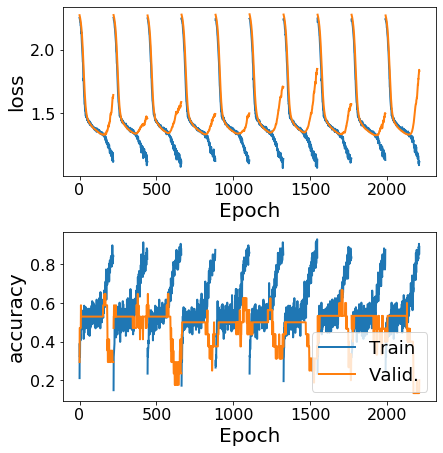

In [26]:
from indl.metrics import quickplot_history

history, accuracy = get_hists_acc(sess_infos[0]['exp_code'], verbose=2)
quickplot_history(history)

### Training and evaluation - per session

Note that using verbose=0 will suppress most of the log information. Progress indicators might only be updated once every few minutes, depending on the number of epochs and the amount of time it takes to process a session.

In [52]:
hists = []
accs = []
for sess_info in sess_infos:
    _hist, _acc = get_hists_acc(sess_info['exp_code'], verbose=0)
    hists.append(_hist)
    accs.append(_acc)
    
print(accs)

Processing session sra3_2_j_037_00+03...
Found 160 trials, 171 timestamps(-0.25 to 1.45 at 100.0 Hz), 32 channels
Returning Y as sacClass with shape (160, 1).
Axis info has: dict_keys(['instance_data', 'instance_times', 'fs', 'timestamps', 'channel_names', 'channel_locs'])
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_2_j_037_00+03 overall accuracy: 63.75%
Processing session sra3_1_j_050_00+...
Found 285 trials, 171 timestamps(-0.25 to 1.45 at 100.0 Hz), 32 channels
Returning Y as sacClass with shape (285, 1).
Axis info has: dict_keys(['instance_data', 'instance_times', 'fs', 'timestamps', 'channel_names', 'channel_locs'])
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_050_00+ overall accuracy: 88.42105263157895%
Processing session sra3_1_j_051_00+...